In [1]:
from src import Frame, Rectangle, VideoReader, VideoWriter, find_module
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

SHADOW = 55
INSIDE = 139
OUTSIDE = 198
WHITE = 255

ITEM_SLOT_TEMPLATE = Frame.from_file('./templates/item_slot.png')

def unique_with_at_least(values, count_threshold):
    return [val for val, count in zip(*np.unique(values, return_counts=True)) if count >= count_threshold]

def find_item_slots(frame):
    filtered = frame.median_blur(3).bilateral_filter()
    highlights = filtered.hsv_range((0,0,225),(255,255,255))
    shadows = filtered.hsv_range((0,0,40),(255,255,100))
    contours = (highlights | shadows).dilate(kernel=np.array([[1,0,0],[0,1,0],[0,0,1]], dtype=np.uint8)).find_contours()
    approxes = []
    squares = []
    for contour in contours:
        approx = contour.convex_hull().approx_poly(0.05)
        rect = Rectangle.from_contour(approx, mode='bound')
        ratio = min(rect.width,rect.height) / max(rect.width,rect.height)
        approxes.append(approx)
        # If it is larger than 10px across
        if rect.width == rect.height and rect.width > 10:        
            squares.append(rect)
    
    if not len(squares):
        return None
    
    values, counts = np.unique([square.width for square in squares], return_counts=True)
    most_common_size = values[counts.argmax()]
    slots = [square for square in squares if square.width == most_common_size]
    
    all_slots = []
    for y in unique_with_at_least([s.y1 for s in slots], 2):
        slot_row = []
        for x in unique_with_at_least([s.x1 for s in slots], 2):
            slot_row.append(Rectangle(x,y,x+most_common_size,y+most_common_size))
        all_slots = slot_row + all_slots
    
#     img = (frame*0)
#     img.draw_contours(contours, color=(70,70,70), replace=True)
#     img.draw_contours(approxes, color=(150,150,150), replace=True)
#     img.draw_rectangles(squares,color=(255,255,255), replace=True)
    return all_slots

In [2]:
frame = Frame.from_file('./tests/images/chest.2.png')
module = find_module(frame)
frame = frame[module.y1:module.y2,module.x1:module.x2]
slots = find_item_slots(frame)
frame.draw_rectangles(slots, thickness=2)

<Frame (499, 525, 3)>

In [2]:
vid = VideoReader('tests/videos/modules.mp4')
with VideoWriter('slots.mp4', fourcc='H264', fps=30, size=vid.size) as out1:
    with VideoWriter('not_slots.mp4', fourcc='H264', fps=30, size=vid.size) as out2:
        for frame in vid:
            module = find_module(frame)
            frame.draw_text(str(vid.pos), (frame.width//3,30), replace=True)
            if module:
                slots = find_item_slots(frame[module.y1:module.y2,module.x1:module.x2])                
                if slots:
                    for slot in slots:
                        frame.draw_rectangle(Rectangle(
                            module.x1+slot.x1,
                            module.y1+slot.y1,
                            module.x2+slot.x2,
                            module.y2+slot.y2,
                        ), thickness=2, replace=True)
                    out1.write(frame)
                else:
                    out2.write(frame)
            else:
                out2.write(frame)

In [108]:
def unique_with_at_least(values, count_threshold):
    return [val for val, count in zip(*np.unique(values, return_counts=True)) if count >= count_threshold]

slot_grid = []
size = slots[0].width
for y in unique_with_at_least([s.y1 for s in slots], 2):
    slot_row = []
    for x in unique_with_at_least([s.x1 for s in slots], 2):
        slot_row.append(Rectangle(x,y,x+size,y+size))
    slot_grid = slot_row + slot_grid

# slot = slot_grid[0][8]
# frame.draw_rectangle(slot_grid[0][8])
# np.ndarray.flatten(slot_grid)

<Frame (499, 525, 3)>

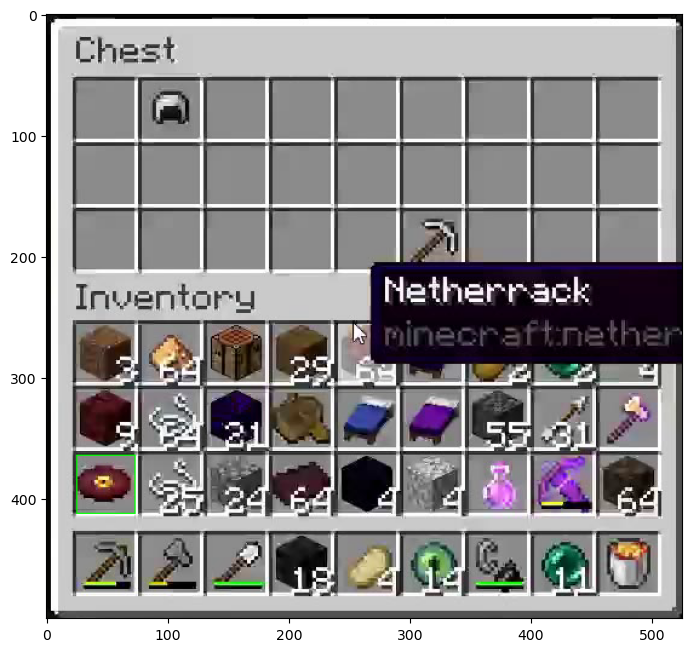

In [113]:
frame.draw_rectangle(slot_grid[9])

3.0

In [5]:
slots[0].size

AttributeError: 'Rectangle' object has no attribute 'size'

<Frame (18, 18, 3)>

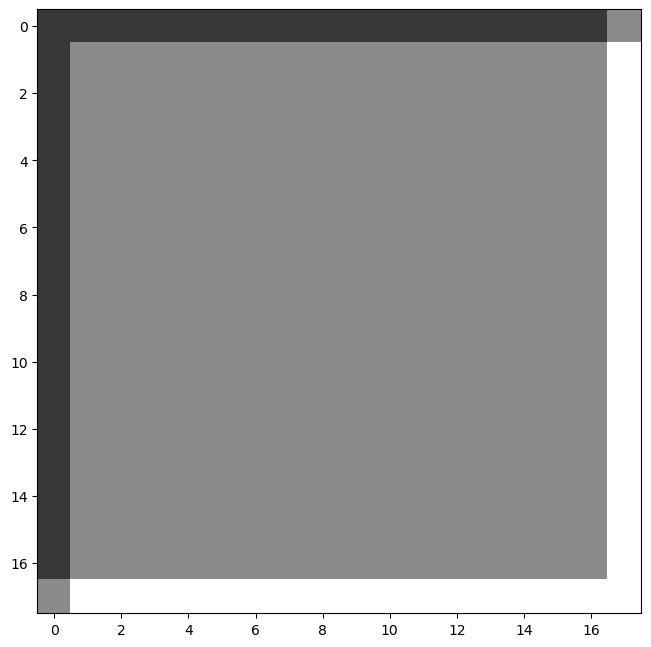

In [273]:
ITEM_SLOT_TEMPLATE

<Frame (18, 18, 3)>

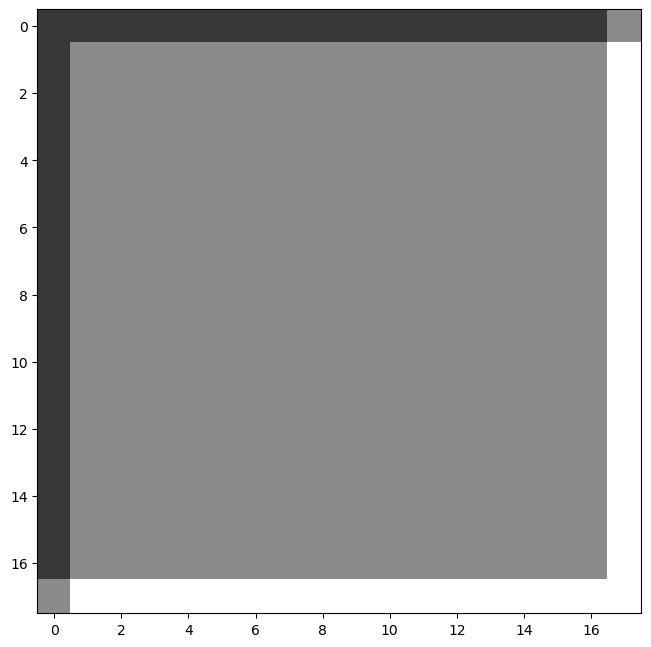

In [267]:
Frame.from_file('./templates/item_slot.png')

<Frame (84, 169, 3)>

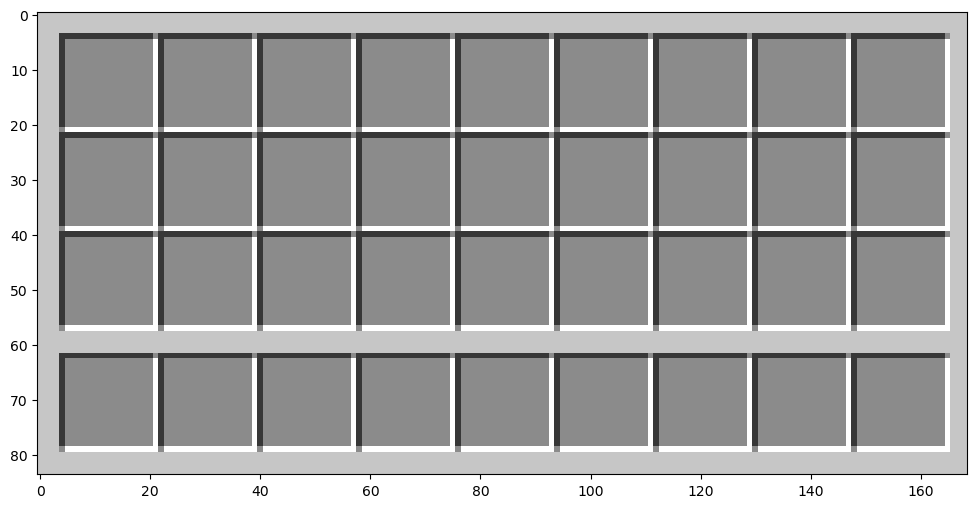

In [53]:
inv = Frame.from_file('./inventory.png')[1:165,1:175]
inv = inv[78:-2,2:-3,:]
inv

<Frame (18, 18, 3)>

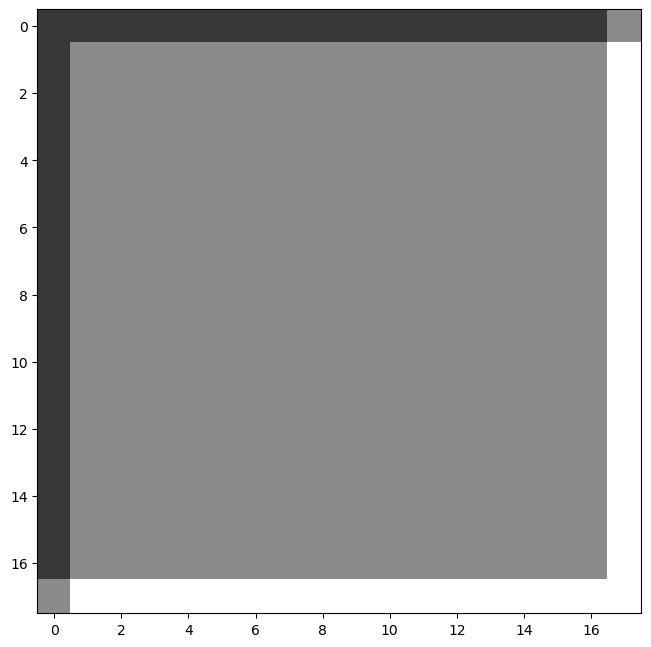

In [236]:
inv[4:22,4:22].write('./templates/item_slot.png')

In [59]:
np.unique(np.ndarray.flatten(inv[:,:,2].view(np.ndarray)), )

array([ 55, 139, 198, 255], dtype=uint8)

In [58]:
smudge = 5
img = np.ones(frame.shape[:2], np.uint8) * INSIDE
for color in [SHADOW, INSIDE, OUTSIDE, WHITE]:
    img = np.where(frame.hsv_range((0,0,color-smudge),(0,smudge,color+smudge)), color, img)
img.view(Frame).match_template(template, 'ccoeff')

error: OpenCV(4.5.3) /private/var/folders/24/8k48jl6d249_n_qfxwsl6xvm0000gn/T/pip-req-build-xxsyexfp/opencv/modules/imgproc/src/templmatch.cpp:1164: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'matchTemplate'


<Frame (498, 525)>

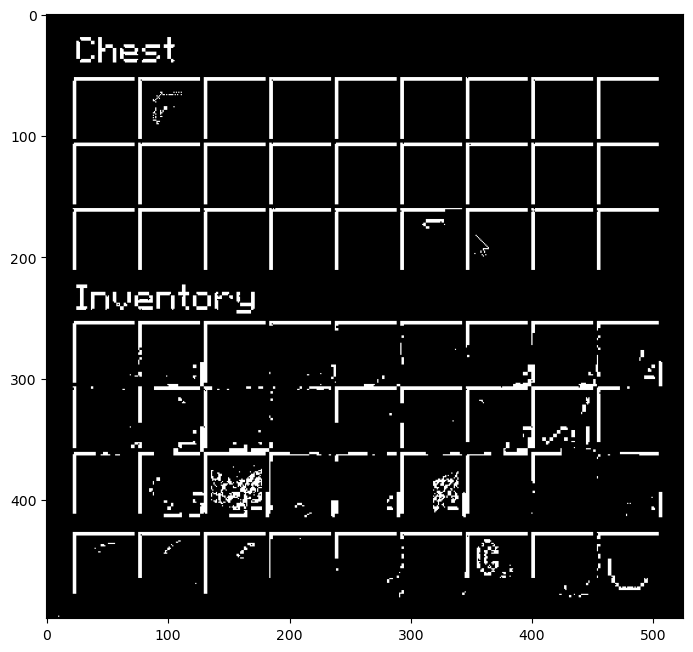

In [147]:
np.where(frame.hsv_range((0,0,SHADOW-smudge),(0,smudge,SHADOW+smudge)), SHADOW, 0).view(Frame)

<Frame (446, 472)>

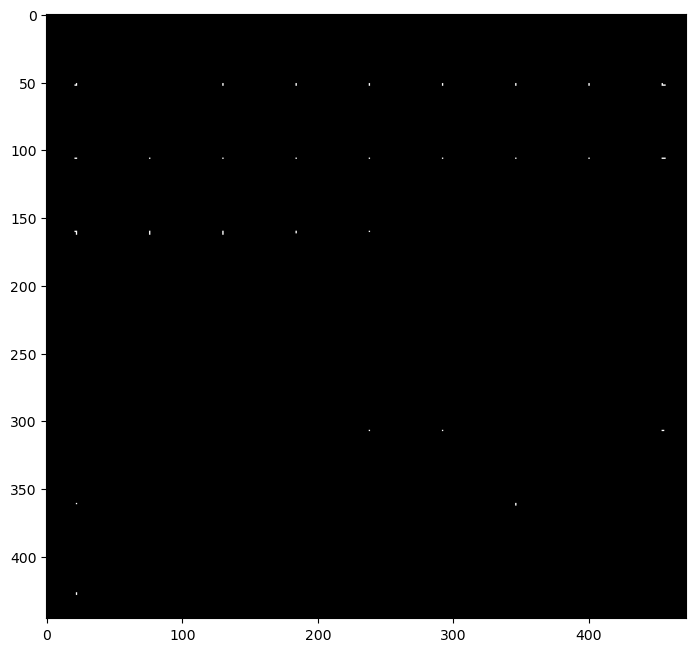

In [73]:
res = np.where(frame.hsv_range((10,10,0),(255,255,255)), INSIDE, frame.gray()).view(Frame).cvt_color('GRAY2BGR').match_template(template, 'ccoeff_normed')
res > 0.8